In [3]:
import csv
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from pyvis.network import Network
%matplotlib inline

import json

import itertools
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from community import (
    partition_at_level,
    modularity,
    best_partition,
    generate_dendrogram,
    induced_graph,
    load_binary,
)
pd.set_option('display.max_rows', None)

In [4]:
path = r"C:/Users/manas/Documents/Master Thesis/code/Manasa2022/skill_id/co-occurence/"
filename = 'co-occurence_python_proper_order.csv'

#word count for co-occurrence as f edge attribute
df_occMatrix = pd.read_csv(path + filename)
#df_occMatrix.rename(columns = {'Source_elt':'Source', 'Target_elt':'Target'}, inplace = True)
df_occMatrix.head()

,Source_elt,Target_elt,WeightCount
0,7.0,7.0,0
1,7.0,14.0,0
2,7.0,21.0,0
3,7.0,22.0,0
4,7.0,34.0,0


In [5]:
path_word = r'C:/Users/manas/Documents/Master Thesis/code/Manasa2022/skill_id/word2vec/'
filename_word  = 'weight_cosine.csv'

#cosine similarity as c edge attribute
word_vectors = pd.read_csv(path_word + filename_word)
word_vectors.head()

,Source,Target,weight_cosine
0,7.0,7.0,1.000000
1,7.0,14.0,-0.021929
2,7.0,21.0,0.003985
3,7.0,22.0,-0.055018
4,7.0,34.0,0.055545


In [6]:
#Merge tables
df_new = pd.concat([word_vectors, df_occMatrix],axis=1, sort=True)
df_new = df_new.drop(['Source_elt', 'Target_elt'], axis=1)
df_new.head()

,Source,Target,weight_cosine,WeightCount
0,7.0,7.0,1.000000,0
1,7.0,14.0,-0.021929,0
2,7.0,21.0,0.003985,0
3,7.0,22.0,-0.055018,0
4,7.0,34.0,0.055545,0


In [7]:
#drop rows with count of co-occurrences zero and rows with cosine similarity zero and lower
df_new = df_new[(df_new['WeightCount'] > 0) & (df_new['weight_cosine'] > 0)]
df_new.reset_index(inplace=True)
df_new = df_new.drop(['index'], axis=1)
df_new.sort_values(by=['WeightCount'], inplace=True, ascending=False)
#print(len(df_new))
df_new.head()

,Source,Target,weight_cosine,WeightCount
644849,977782.0,958531.0,0.008294,43850
298835,958531.0,977782.0,0.008294,43850
465075,972787.0,972468.0,0.136831,39423
373608,972468.0,972787.0,0.136831,39423
297679,958531.0,954527.0,0.006997,31622


In [8]:
df_new.head(5)

,Source,Target,weight_cosine,WeightCount
644849,977782.0,958531.0,0.008294,43850
298835,958531.0,977782.0,0.008294,43850
465075,972787.0,972468.0,0.136831,39423
373608,972468.0,972787.0,0.136831,39423
297679,958531.0,954527.0,0.006997,31622


In [9]:
def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    new_frame.reset_index(inplace=True)
    new_frame = new_frame.drop(['index'], axis=1)
    return new_frame

selected_columns = ['Source', 'Target']

In [10]:
def reset_rename(data_frame):
    data_frame.reset_index(inplace=True)
    new_frame = data_frame.rename(columns={'index': 'Source'})
    return new_frame

In [11]:
def resetIndex(data_frame):
    data_frame.reset_index(inplace=True)
    new_frame = data_frame.drop(['index'], axis=1)
    return new_frame

In [12]:
def connectcluster(data):
    sourcelist = data['Source'].tolist()
    targetlist = data['Target'].tolist()
    for val in targetlist:
        if val not in sourcelist:
            data = data[data.Target != val]
    return data

In [13]:
nodes_layer_1 = select_columns(df_new, selected_columns)
nodes_layer_1.head()

,Source,Target
0,977782.0,958531.0
1,958531.0,977782.0
2,972787.0,972468.0
3,972468.0,972787.0
4,958531.0,954527.0


In [14]:
len(nodes_layer_1)

891306

In [85]:
sample_nodes_layer_1 =nodes_layer_1.head(1000)

In [ ]:
best_partition = None
best_mod = 0
for x in range(100):
    WeightCount = []
    weight_cosine =[]
    for i in range(len(sample_nodes_layer_1)):
        weight_cosine.append(pd.DataFrame(df_new['weight_cosine']).sample(500, replace=True).weight_cosine.mean())
        WeightCount.append(pd.DataFrame(df_new['WeightCount']).sample(500, replace=True).WeightCount.mean())
        boot = pd.DataFrame({'weight_cosine':weight_cosine, 'WeightCount' :WeightCount})
    bootstrapgraph = pd.concat([sample_nodes_layer_1, boot],axis=1, sort=True)

In [116]:
bootstrapgraph.head(10)

,Source,Target,weight_cosine,WeightCount
0,977782.0,958531.0,0.073028,13.51
1,958531.0,977782.0,0.081068,27.20
2,972787.0,972468.0,0.096737,121.83
3,972468.0,972787.0,0.081895,33.11
4,958531.0,954527.0,0.089092,19.41
5,954527.0,958531.0,0.075066,10.42
6,956733.0,958531.0,0.077075,26.54
7,958531.0,956733.0,0.075652,66.40
8,954527.0,972533.0,0.082469,46.36
9,972533.0,954527.0,0.076533,42.75


In [117]:
out = pd.Series(map(frozenset,zip(bootstrapgraph['Source'],bootstrapgraph['Target'])))

In [118]:
bootstrapgraph['duplicates']=out
bootstrapgraph.head(5)

,Source,Target,weight_cosine,WeightCount,duplicates
0,977782.0,958531.0,0.073028,13.51,"(958531.0, 977782.0)"
1,958531.0,977782.0,0.081068,27.20,"(958531.0, 977782.0)"
2,972787.0,972468.0,0.096737,121.83,"(972787.0, 972468.0)"
3,972468.0,972787.0,0.081895,33.11,"(972787.0, 972468.0)"
4,958531.0,954527.0,0.089092,19.41,"(958531.0, 954527.0)"


In [ ]:
#example
df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})

In [120]:
# merge these duplicates because of undirected graph
bootstrapgraph = bootstrapgraph.groupby('duplicates').agg({'Source':'first', 'Target':'first','WeightCount':'sum', 'weight_cosine':'sum'}).reset_index(drop=True)

# create a summed weight score (implies greater relevance for co-occurrence frequency due to scaling)
bootstrapgraph['sum_weight'] = bootstrapgraph['WeightCount'] + bootstrapgraph['weight_cosine'] 

print(bootstrapgraph.shape)
bootstrapgraph.head()

(500, 5)


,Source,Target,WeightCount,weight_cosine,sum_weight
0,977782.0,958531.0,40.71,0.154096,40.864096
1,957474.0,972565.0,32.86,0.158097,33.018097
2,972587.0,956605.0,64.82,0.166651,64.986651
3,972548.0,957464.0,113.61,0.169001,113.779001
4,956747.0,972833.0,68.50,0.174159,68.674159


In [121]:
# copy the data,trying to normalize the data
df_min_max_scaled = df_new.copy()

In [11]:
df_min_max_scaled.head(3)

,Source,Target,WeightCount,weight_cosine,sum_weight
0,977782.0,958531.0,43852,0.179736,43852.179736
1,974694.0,957074.0,4,0.103813,4.103813
2,955769.0,954469.0,4,0.283691,4.283691


In [12]:
# apply normalization techniques by WeightCount
column = 'WeightCount'
df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    

In [13]:
df_min_max_scaled.head(5)

,Source,Target,WeightCount,weight_cosine,sum_weight
0,977782.0,958531.0,0.998838,0.179736,43852.179736
1,974694.0,957074.0,0.000046,0.103813,4.103813
2,955769.0,954469.0,0.000046,0.283691,4.283691
3,1589294.0,1609453.0,0.000046,0.223675,4.223675
4,958252.0,956339.0,0.000046,0.346372,4.346372


In [28]:
#reading the vertices
skills_labels = pd.read_csv(r"C:\Users\manas\Documents\Master Thesis\code\Manasa2022\skill_id\testing\skill_id_from_word2vec.csv")
skills_labels.head(3)

,skill_id
0,7.0
1,14.0
2,21.0


In [122]:
#construct graph using igraph library
import igraph
from igraph import Graph, compare_communities, drawing
G =  igraph.Graph.DataFrame(bootstrapgraph, directed=False, use_vids=False)

In [123]:
# check number of vertices and edges
nr_vertices = G.vcount()
nr_edges = G.ecount()
print(f' The graph has {nr_vertices} vertices and {nr_edges} edges.')

 The graph has 141 vertices and 500 edges.


In [124]:
# get degrees and eigenvector centrality for vertices
#Vertex degree: number of edges adjacent to it.
#Eigenvector centrality: measure of the influence of a node in a network. A high eigenvector score means 
#that a vertex is connected to many nodes who themselves have high scores.
degree = G.degree()
eig_centr = G.eigenvector_centrality()
print(f'The highest number of degrees is {G.maxdegree()}')
print(f'The highest eigenvector centrality score is {max(eig_centr)}')

The highest number of degrees is 44
The highest eigenvector centrality score is 1.0


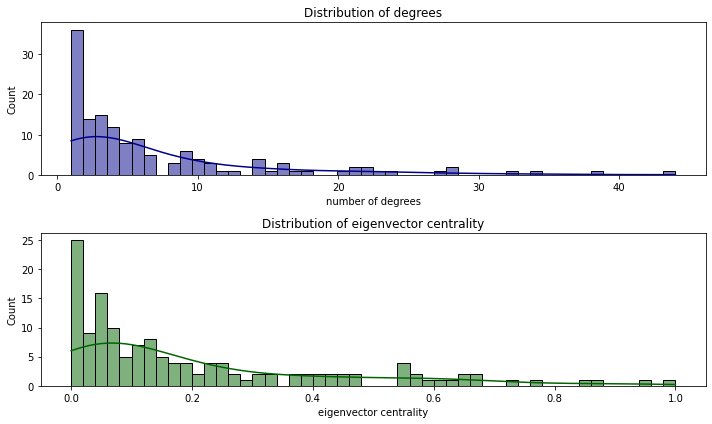

In [125]:
# plot degree and eigenvector centrality distributions
import seaborn as sns
fig, axs = plt.subplots(2,1, tight_layout=True, figsize=(10,6))

sns.histplot(degree, kde=True, bins=50, color = 'darkblue', ax=axs[0])
sns.histplot(eig_centr, kde=True, bins=50, color = 'darkgreen', ax=axs[1])

axs[0].set(title='Distribution of degrees', xlabel='number of degrees')
axs[1].set(title='Distribution of eigenvector centrality', xlabel='eigenvector centrality')

plt.show()

In [126]:
print(f' The skill with the most adjacent edges to it is: {G.vs.select(_degree = G.maxdegree())["name"]}')

 The skill with the most adjacent edges to it is: [958531.0]


In [127]:
# using co-occurrence frequency as edge weights
louv_freq_coms_lay1 = G.community_multilevel(weights='WeightCount')
louv_freq_mod_lay1 = G.modularity(louv_freq_coms_lay1, weights='WeightCount')

In [128]:
print(f'{len(louv_freq_coms_lay1)} clusters were detected, with the following sizes:{louv_freq_coms_lay1.sizes()}')

11 clusters were detected, with the following sizes:[2, 24, 21, 37, 13, 5, 15, 18, 2, 2, 2]


In [129]:
# using cosine similarity as edge weights
louv_cs_coms_lay1 = G.community_multilevel(weights='weight_cosine')
louv_cs_mod_lay1 = G.modularity(louv_cs_coms_lay1, weights='weight_cosine')

In [130]:
print(f'{len(louv_cs_coms_lay1)} clusters were detected, with the following sizes:{louv_cs_coms_lay1.sizes()}')

10 clusters were detected, with the following sizes:[2, 30, 33, 23, 24, 5, 11, 9, 2, 2]


In [131]:
# using the sum score as edge weights
louv_sum_coms_lay1 = G.community_multilevel(weights='sum_weight')
louv_sum_mod_lay1 = G.modularity(louv_cs_coms_lay1, weights='sum_weight')

In [132]:
print(f'{len(louv_sum_coms_lay1)} clusters were detected, with the following sizes:{louv_sum_coms_lay1.sizes()}')

12 clusters were detected, with the following sizes:[2, 2, 21, 29, 23, 13, 5, 23, 7, 12, 2, 2]


In [133]:
# compare modularity scores across the different Louvain partitions
print(f'modularity for partition with co-occurence as edge weights: {louv_freq_mod_lay1}')
print(f'modularity for partition with cosine similarity as edge weights: {louv_cs_mod_lay1}')
print(f'modularity for partition with sum weight as edge weights: {louv_sum_mod_lay1}')

modularity for partition with co-occurence as edge weights: 0.3905001753144542
modularity for partition with cosine similarity as edge weights: 0.37271890348091946
modularity for partition with sum weight as edge weights: 0.37083192041413615


In [134]:
# check resemblance between Louvain community detection solutions
louv_nmi1 = compare_communities(louv_freq_coms_lay1, louv_cs_coms_lay1, method="nmi")
louv_nmi2 = compare_communities(louv_freq_coms_lay1, louv_sum_coms_lay1, method="nmi")
louv_nmi3 = compare_communities(louv_cs_coms_lay1, louv_sum_coms_lay1, method="nmi")
print(f'NMI comparing co-occurence frequency vs. cosine similarity as edge weights: {louv_nmi1}')
print(f'NMI comparing co-occurence frequency vs. summed score as edge weights: {louv_nmi2}')
print(f'NMI comparing cosine similarity vs. summed score as edge weights: {louv_nmi3}')

NMI comparing co-occurence frequency vs. cosine similarity as edge weights: 0.625529485082621
NMI comparing co-occurence frequency vs. summed score as edge weights: 0.7278531917059898
NMI comparing cosine similarity vs. summed score as edge weights: 0.6083756980895814


In [135]:
# using co-occurrence frequency as edge weights
leid_freq_coms_lay1 = G.community_leiden(objective_function="modularity", weights='WeightCount',
                                      n_iterations=1000)
leid_freq_mod_lay1 = G.modularity(leid_freq_coms_lay1, weights='WeightCount')

In [136]:
print(leid_freq_mod_lay1)

0.39851406516069754


In [137]:
print(f'{len(leid_freq_coms_lay1)} clusters were detected, with the following sizes:{leid_freq_coms_lay1.sizes()}')

11 clusters were detected, with the following sizes:[2, 30, 27, 34, 16, 5, 14, 7, 2, 2, 2]


In [138]:
# using cosine similarity as edge weights
leid_cs_coms_lay1 = G.community_leiden(objective_function="modularity", weights='weight_cosine',
                                      n_iterations=1000)
leid_cs_mod_lay1 = G.modularity(leid_cs_coms_lay1, weights='weight_cosine')

In [139]:
print(f'{len(leid_cs_coms_lay1)} clusters were detected, with the following sizes:{leid_cs_coms_lay1.sizes()}')

10 clusters were detected, with the following sizes:[2, 10, 32, 24, 33, 22, 5, 9, 2, 2]


In [140]:
# using the sum score as edge weights
leid_sum_coms_lay1 = G.community_leiden(objective_function="modularity", weights='sum_weight',
                                      n_iterations=1000)
leid_sum_mod_lay1 = G.modularity(leid_sum_coms_lay1, weights='sum_weight')

In [141]:
print(leid_sum_mod_lay1)

0.39822663335696284


In [142]:
print(f'{len(leid_sum_coms_lay1)} clusters were detected, with the following sizes:{leid_sum_coms_lay1.sizes()}')

10 clusters were detected, with the following sizes:[2, 19, 25, 31, 23, 5, 25, 7, 2, 2]


In [114]:
# compare modularity scores across the different Leiden partitions
print(f'modularity for partition with co-occurence as edge weights: {leid_freq_mod_lay1}')
print(f'modularity for partition with cosine similarity as edge weights: {leid_cs_mod_lay1}')
print(f'modularity for partition with sum weight as edge weights: {leid_sum_mod_lay1}')

modularity for partition with co-occurence as edge weights: 0.3836045999402174
modularity for partition with cosine similarity as edge weights: 0.3846376067487418
modularity for partition with sum weight as edge weights: 0.381430602233401


In [80]:
# check resemblance between Louvain community detection solutions
leid_nmi1 = compare_communities(leid_freq_coms_lay1, leid_cs_coms_lay1, method="nmi")
leid_nmi2 = compare_communities(leid_freq_coms_lay1, leid_sum_coms_lay1, method="nmi")
leid_nmi3 = compare_communities(leid_cs_coms_lay1, leid_sum_coms_lay1, method="nmi")
print(f'NMI comparing co-occurence frequency vs. cosine similarity as edge weights: {leid_nmi1}')
print(f'NMI comparing co-occurence frequency vs. summed score as edge weights: {leid_nmi2}')
print(f'NMI comparing cosine similarity vs. summed score as edge weights: {leid_nmi3}')

NMI comparing co-occurence frequency vs. cosine similarity as edge weights: 1.0
NMI comparing co-occurence frequency vs. summed score as edge weights: 1.0
NMI comparing cosine similarity vs. summed score as edge weights: 1.0


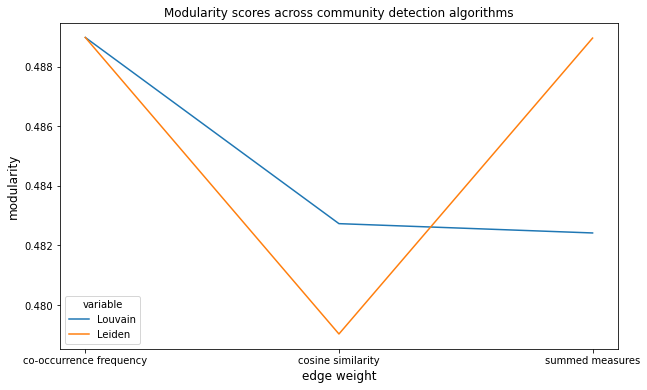

In [84]:
# plot modularity scores for the three different algorithms

x=['co-occurrence frequency','cosine similarity', 'summed measures']
y_louv=[louv_freq_mod_lay1, louv_cs_mod_lay1, louv_sum_mod_lay1]
y_leid=[leid_freq_mod_lay1, leid_cs_mod_lay1, leid_sum_mod_lay1]

modul_data = pd.DataFrame({'edge weight': x, 'Louvain': y_louv, 'Leiden': y_leid})

plt.figure(figsize=(10,6))
sns.lineplot(x='edge weight', y='value', hue='variable', data=pd.melt(modul_data, ['edge weight']))
plt.title('Modularity scores across community detection algorithms')
plt.xlabel("edge weight", fontsize='large')
plt.ylabel("modularity", fontsize='large')
plt.show()

In [46]:
# get cluster allocation of skills for layer 1 of taxonomy
lay1_c_list = pd.Series(leid_sum_coms_lay1.membership)
lay1_skills = pd.Series(G.vs["name"])

layer1_df=pd.concat([lay1_skills, lay1_c_list], axis=1)
layer1_df.rename(columns={0:"skill_id", 1:"c_layer1"}, inplace=True)
layer1_df.head(10)

,skill_id,c_layer1
0,954335.0,0
1,954426.0,1
2,954527.0,2
3,954574.0,1
4,954589.0,3
5,954791.0,4
6,954841.0,3
7,954981.0,4
8,955020.0,5
9,955034.0,1


In [47]:
#Layer 2 of skills taxonomy
len(leid_sum_coms_lay1)

10

In [48]:
#second layer 
for i in range(len(leid_sum_coms_lay1)):
    
    if i == 0:
        G2_0 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_0 = G2_0.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_0 = G2_0.modularity(leid_sum_coms_lay2_0, weights='sum_weight')
    elif i == 1:
        G2_1 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_1 = G2_1.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_1 = G2_1.modularity(leid_sum_coms_lay2_1, weights='sum_weight')
    elif i == 2:
        G2_2 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_2 = G2_2.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_2 = G2_2.modularity(leid_sum_coms_lay2_2, weights='sum_weight')
    elif i == 3:
        G2_3 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_3 = G2_3.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_3 = G2_3.modularity(leid_sum_coms_lay2_3, weights='sum_weight')
    elif i == 4:
        G2_4 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_4 = G2_4.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_4 = G2_4.modularity(leid_sum_coms_lay2_4, weights='sum_weight')
    elif i == 5:
        G2_5 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_5 = G2_5.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_5 = G2_5.modularity(leid_sum_coms_lay2_5, weights='sum_weight')
    elif i == 6:
        G2_6 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_6 = G2_6.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_6 = G2_6.modularity(leid_sum_coms_lay2_6, weights='sum_weight')
    elif i == 7:
        G2_7 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_7 = G2_7.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_7 = G2_7.modularity(leid_sum_coms_lay2_7, weights='sum_weight')
    elif i == 8:
        G2_8 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_8 = G2_8.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_8 = G2_8.modularity(leid_sum_coms_lay2_8, weights='sum_weight')
    elif i == 9:
        G2_9 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_9 = G2_9.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_9 = G2_9.modularity(leid_sum_coms_lay2_9, weights='sum_weight')
    elif i == 10:
        G2_10 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_10 = G2_10.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_10 = G2_10.modularity(leid_sum_coms_lay2_10, weights='sum_weight')
    elif i == 11:
        G2_11 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_11 = G2_11.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_11 = G2_11.modularity(leid_sum_coms_lay2_11, weights='sum_weight')     
    elif i == 12:
        G2_12 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_12 = G2_12.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_12 = G2_12.modularity(leid_sum_coms_lay2_12, weights='sum_weight')
    elif i == 13 :
        G2_13 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_13 = G2_13.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_13 = G2_13.modularity(leid_sum_coms_lay2_13, weights='sum_weight')
    elif i == 14:
        G2_14 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_14 = G2_14.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_14 = G2_14.modularity(leid_sum_coms_lay2_14, weights='sum_weight')
    elif i == 15:
        G2_15 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_15 = G2_15.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_15 = G2_15.modularity(leid_sum_coms_lay2_15, weights='sum_weight')
    elif i == 16:
        G2_16 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_16 = G2_16.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_16 = G2_16.modularity(leid_sum_coms_lay2_16, weights='sum_weight')
    elif i == 17:
        G2_17 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_17 = G2_17.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_17 = G2_17.modularity(leid_sum_coms_lay2_17, weights='sum_weight')
    elif i == 18:
        G2_18 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_18 = G2_18.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_18 = G2_18.modularity(leid_sum_coms_lay2_18, weights='sum_weight')
    elif i == 19:
        G2_19 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_19 = G2_19.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_19 = G2_19.modularity(leid_sum_coms_lay2_19, weights='sum_weight')
    elif i == 20:
        G2_20 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_20 = G2_20.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_20 = G2_20.modularity(leid_sum_coms_lay2_20, weights='sum_weight')
    elif i == 21:
        G2_21 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_21 = G2_21.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_21 = G2_21.modularity(leid_sum_coms_lay2_21, weights='sum_weight')
    elif i == 22:
        G2_22 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_22 = G2_22.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_22 = G2_22.modularity(leid_sum_coms_lay2_22, weights='sum_weight')
    elif i == 23:
        G2_23 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_23 = G2_23.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_23 = G2_23.modularity(leid_sum_coms_lay2_23, weights='sum_weight')
    elif i == 24:
        G2_24 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_24 = G2_24.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_24 = G2_24.modularity(leid_sum_coms_lay2_24, weights='sum_weight')     
    elif i == 25:
        G2_25 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_25 = G2_25.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_25 = G2_25.modularity(leid_sum_coms_lay2_25, weights='sum_weight')
    elif i == 26 :
        G2_26 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_26 = G2_26.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_26 = G2_26.modularity(leid_sum_coms_lay2_26, weights='sum_weight')
    elif i == 27:
        G2_27 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_27 = G2_27.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_27 = G2_27.modularity(leid_sum_coms_lay2_27, weights='sum_weight')
    elif i == 28:
        G2_28 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_28 = G2_28.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_28 = G2_28.modularity(leid_sum_coms_lay2_28, weights='sum_weight')
    elif i == 29:
        G2_29 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_29 = G2_29.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_29 = G2_29.modularity(leid_sum_coms_lay2_29, weights='sum_weight')
    elif i == 30:
        G2_30 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_30 = G2_30.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_30 = G2_30.modularity(leid_sum_coms_lay2_30, weights='sum_weight')
    elif i == 31:
        G2_31 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_31 = G2_31.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_31 = G2_31.modularity(leid_sum_coms_lay2_31, weights='sum_weight')
    elif i == 32:
        G2_32 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_32 = G2_32.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_32 = G2_32.modularity(leid_sum_coms_lay2_32, weights='sum_weight')
    elif i == 33:
        G2_33 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_33 = G2_33.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_33 = G2_33.modularity(leid_sum_coms_lay2_33, weights='sum_weight')
    elif i == 34:
        G2_34 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_34 = G2_34.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_34 = G2_34.modularity(leid_sum_coms_lay2_34, weights='sum_weight')
    elif i == 35:
        G2_35 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_35 = G2_35.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_35 = G2_35.modularity(leid_sum_coms_lay2_35, weights='sum_weight')
    elif i == 36:
        G2_36 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_36 = G2_36.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_36 = G2_36.modularity(leid_sum_coms_lay2_36, weights='sum_weight')
    elif i == 37:
        G2_37 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_37 = G2_37.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
        leid_sum_mod_lay2_37 = G2_37.modularity(leid_sum_coms_lay2_37, weights='sum_weight')     

In [ ]:
# check nested cluster structure and modularity
print(f'{len(leid_sum_coms_lay2_0)} clusters were detected nested under cluster 0 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_0.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_0}.\n')    
print(f'{len(leid_sum_coms_lay2_1)} clusters were detected nested under cluster 1 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_1.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_1}.\n')  
print(f'{len(leid_sum_coms_lay2_2)} clusters were detected nested under cluster 2 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_2.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_2}.\n')    
print(f'{len(leid_sum_coms_lay2_3)} clusters were detected nested under cluster 3 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_3.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_3}.\n')    
print(f'{len(leid_sum_coms_lay2_4)} clusters were detected nested under cluster 4 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_4.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_4}.\n')    
print(f'{len(leid_sum_coms_lay2_5)} clusters were detected nested under cluster 5 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_5.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_5}.\n')    
print(f'{len(leid_sum_coms_lay2_6)} clusters were detected nested under cluster 6 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_6.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_6}.\n')    
print(f'{len(leid_sum_coms_lay2_7)} clusters were detected nested under cluster 7 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_7.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_7}.\n')    
print(f'{len(leid_sum_coms_lay2_8)} clusters were detected nested under cluster 8 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_8.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_8}.\n')    
print(f'{len(leid_sum_coms_lay2_9)} clusters were detected nested under cluster 9 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_9.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_9}.\n')    
print(f'{len(leid_sum_coms_lay2_10)}clusters were detected nested under cluster 10 from layer 1.\nThese nested clusters have the following sizes:{leid_sum_coms_lay2_10.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_10}.\n')    
print(f'{len(leid_sum_coms_lay2_11)}clusters were detected nested under cluster 11 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_11.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_11}.\n')    
print(f'{len(leid_sum_coms_lay2_12)}clusters were detected nested under cluster 12 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_12.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_12}.\n')
print(f'{len(leid_sum_coms_lay2_13)}clusters were detected nested under cluster 13 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_13.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_13}.\n')
# check nested cluster structure and modularity
print(f'{len(leid_sum_coms_lay2_14)} clusters were detected nested under cluster 14 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_14.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_14}.\n')    
print(f'{len(leid_sum_coms_lay2_15)} clusters were detected nested under cluster 15 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_15.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_15}.\n')  
print(f'{len(leid_sum_coms_lay2_16)} clusters were detected nested under cluster 16 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_16.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_16}.\n')    
print(f'{len(leid_sum_coms_lay2_17)} clusters were detected nested under cluster 17 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_17.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_17}.\n')    
print(f'{len(leid_sum_coms_lay2_18)} clusters were detected nested under cluster 18 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_18.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_18}.\n')    
print(f'{len(leid_sum_coms_lay2_19)} clusters were detected nested under cluster 19 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_19.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_19}.\n')    
print(f'{len(leid_sum_coms_lay2_20)} clusters were detected nested under cluster 20 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_20.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_20}.\n')    
print(f'{len(leid_sum_coms_lay2_21)} clusters were detected nested under cluster 21 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_21.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_21}.\n')    
print(f'{len(leid_sum_coms_lay2_22)} clusters were detected nested under cluster 22 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_22.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_22}.\n')    
print(f'{len(leid_sum_coms_lay2_23)} clusters were detected nested under cluster 23 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_23.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_23}.\n')    
print(f'{len(leid_sum_coms_lay2_24)}clusters were detected nested under cluster 24 from layer 1.\nThese nested clusters have the following sizes:{leid_sum_coms_lay2_24.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_24}.\n')    
print(f'{len(leid_sum_coms_lay2_25)}clusters were detected nested under cluster 25 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_25.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_25}.\n')    
print(f'{len(leid_sum_coms_lay2_26)}clusters were detected nested under cluster 26 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_26.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_26}.\n')
print(f'{len(leid_sum_coms_lay2_27)}clusters were detected nested under cluster 27 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_27.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_27}.\n')
# check nested cluster structure and modularity
print(f'{len(leid_sum_coms_lay2_28)} clusters were detected nested under cluster 28 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_28.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_28}.\n')    
print(f'{len(leid_sum_coms_lay2_29)} clusters were detected nested under cluster 29 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_29.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_29}.\n')  
print(f'{len(leid_sum_coms_lay2_30)} clusters were detected nested under cluster 30 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_30.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_30}.\n')    
print(f'{len(leid_sum_coms_lay2_31)} clusters were detected nested under cluster 31 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_31.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_31}.\n')    
print(f'{len(leid_sum_coms_lay2_32)} clusters were detected nested under cluster 32 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_32.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_32}.\n')    
print(f'{len(leid_sum_coms_lay2_33)} clusters were detected nested under cluster 33 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_33.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_33}.\n')    
print(f'{len(leid_sum_coms_lay2_34)} clusters were detected nested under cluster 34 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_34.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_34}.\n')    
print(f'{len(leid_sum_coms_lay2_35)} clusters were detected nested under cluster 35 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_35.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_35}.\n')    
print(f'{len(leid_sum_coms_lay2_36)} clusters were detected nested under cluster 36 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_36.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_36}.\n')    
print(f'{len(leid_sum_coms_lay2_37)} clusters were detected nested under cluster 37 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_37.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_37}.\n')   


In [ ]:
# get cluster allocation of skills for layer 2 of taxonomy
lay2_c_list0 = pd.Series(leid_sum_coms_lay2_0.membership)
lay2_skills0 = pd.Series(G2_0.vs["name"])
lay2_c_list1 = pd.Series(leid_sum_coms_lay2_1.membership)
lay2_skills1 = pd.Series(G2_1.vs["name"])
lay2_c_list2 = pd.Series(leid_sum_coms_lay2_2.membership)
lay2_skills2 = pd.Series(G2_2.vs["name"])
lay2_c_list3 = pd.Series(leid_sum_coms_lay2_3.membership)
lay2_skills3 = pd.Series(G2_3.vs["name"])
lay2_c_list4 = pd.Series(leid_sum_coms_lay2_4.membership)
lay2_skills4 = pd.Series(G2_4.vs["name"])
lay2_c_list5 = pd.Series(leid_sum_coms_lay2_5.membership)
lay2_skills5 = pd.Series(G2_5.vs["name"])
lay2_c_list6 = pd.Series(leid_sum_coms_lay2_6.membership)
lay2_skills6 = pd.Series(G2_6.vs["name"])
lay2_c_list7 = pd.Series(leid_sum_coms_lay2_7.membership)
lay2_skills7 = pd.Series(G2_7.vs["name"])
lay2_c_list8 = pd.Series(leid_sum_coms_lay2_8.membership)
lay2_skills8 = pd.Series(G2_8.vs["name"])
lay2_c_list9 = pd.Series(leid_sum_coms_lay2_9.membership)
lay2_skills9 = pd.Series(G2_9.vs["name"])
lay2_c_list10 = pd.Series(leid_sum_coms_lay2_10.membership)
lay2_skills10 = pd.Series(G2_10.vs["name"])
lay2_c_list11 = pd.Series(leid_sum_coms_lay2_11.membership)
lay2_skills11 =  pd.Series(G2_11.vs["name"])
lay2_c_list12 = pd.Series(leid_sum_coms_lay2_12.membership)
lay2_skills12 = pd.Series(G2_12.vs["name"])
lay2_c_list13 = pd.Series(leid_sum_coms_lay2_13.membership)
lay2_skills13 = pd.Series(G2_13.vs["name"])
lay2_c_list14 = pd.Series(leid_sum_coms_lay2_14.membership)
lay2_skills14 = pd.Series(G2_14.vs["name"])
lay2_c_list15 = pd.Series(leid_sum_coms_lay2_15.membership)
lay2_skills15 = pd.Series(G2_15.vs["name"])
lay2_c_list16 = pd.Series(leid_sum_coms_lay2_16.membership)
lay2_skills16 = pd.Series(G2_16.vs["name"])
lay2_c_list17 = pd.Series(leid_sum_coms_lay2_17.membership)
lay2_skills17 = pd.Series(G2_17.vs["name"])
lay2_c_list18 = pd.Series(leid_sum_coms_lay2_18.membership)
lay2_skills18 = pd.Series(G2_18.vs["name"])
lay2_c_list19 = pd.Series(leid_sum_coms_lay2_19.membership)
lay2_skills19 = pd.Series(G2_19.vs["name"])
lay2_c_list20 = pd.Series(leid_sum_coms_lay2_20.membership)
lay2_skills20 = pd.Series(G2_20.vs["name"])
lay2_c_list21 = pd.Series(leid_sum_coms_lay2_21.membership)
lay2_skills21 = pd.Series(G2_21.vs["name"])
lay2_c_list22 = pd.Series(leid_sum_coms_lay2_22.membership)
lay2_skills22 = pd.Series(G2_22.vs["name"])
lay2_c_list23 = pd.Series(leid_sum_coms_lay2_23.membership)
lay2_skills23 = pd.Series(G2_23.vs["name"])
lay2_c_list24 = pd.Series(leid_sum_coms_lay2_24.membership)
lay2_skills24 = pd.Series(G2_24.vs["name"])
lay2_c_list25 = pd.Series(leid_sum_coms_lay2_25.membership)
lay2_skills25 = pd.Series(G2_25.vs["name"])
lay2_c_list26 = pd.Series(leid_sum_coms_lay2_26.membership)
lay2_skills26 = pd.Series(G2_26.vs["name"])
lay2_c_list27 = pd.Series(leid_sum_coms_lay2_27.membership)
lay2_skills27 = pd.Series(G2_27.vs["name"])
lay2_c_list28 = pd.Series(leid_sum_coms_lay2_28.membership)
lay2_skills28 = pd.Series(G2_28.vs["name"])
lay2_c_list29 = pd.Series(leid_sum_coms_lay2_29.membership)
lay2_skills29 = pd.Series(G2_29.vs["name"])
lay2_c_list30 = pd.Series(leid_sum_coms_lay2_30.membership)
lay2_skills30 = pd.Series(G2_30.vs["name"])
lay2_c_list31 = pd.Series(leid_sum_coms_lay2_31.membership)
lay2_skills31 = pd.Series(G2_31.vs["name"])
lay2_c_list32 = pd.Series(leid_sum_coms_lay2_32.membership)
lay2_skills32 = pd.Series(G2_32.vs["name"])
lay2_c_list33 = pd.Series(leid_sum_coms_lay2_33.membership)
lay2_skills33 = pd.Series(G2_33.vs["name"])
lay2_c_list34 = pd.Series(leid_sum_coms_lay2_34.membership)
lay2_skills34 = pd.Series(G2_34.vs["name"])
lay2_c_list35 = pd.Series(leid_sum_coms_lay2_35.membership)
lay2_skills35 = pd.Series(G2_35.vs["name"])
lay2_c_list36 = pd.Series(leid_sum_coms_lay2_36.membership)
lay2_skills36 = pd.Series(G2_36.vs["name"])
lay2_c_list37 = pd.Series(leid_sum_coms_lay2_37.membership)
lay2_skills37 = pd.Series(G2_37.vs["name"])


temp_df0=pd.concat([lay2_skills0, lay2_c_list0], axis=1)
temp_df1=pd.concat([lay2_skills1, lay2_c_list1], axis=1)
temp_df2=pd.concat([lay2_skills2, lay2_c_list2], axis=1)
temp_df3=pd.concat([lay2_skills3, lay2_c_list3], axis=1)
temp_df4=pd.concat([lay2_skills4, lay2_c_list4], axis=1)
temp_df5=pd.concat([lay2_skills5, lay2_c_list5], axis=1)
temp_df6=pd.concat([lay2_skills6, lay2_c_list6], axis=1)
temp_df7=pd.concat([lay2_skills7, lay2_c_list7], axis=1)
temp_df8=pd.concat([lay2_skills8, lay2_c_list8], axis=1)
temp_df9=pd.concat([lay2_skills9, lay2_c_list9], axis=1)
temp_df10=pd.concat([lay2_skills10, lay2_c_list10], axis=1)
temp_df11=pd.concat([lay2_skills11, lay2_c_list11], axis=1)
temp_df12=pd.concat([lay2_skills12, lay2_c_list12], axis=1)
temp_df13=pd.concat([lay2_skills13, lay2_c_list13], axis=1)
temp_df14=pd.concat([lay2_skills14, lay2_c_list14], axis=1)
temp_df15=pd.concat([lay2_skills15, lay2_c_list15], axis=1)
temp_df16=pd.concat([lay2_skills16, lay2_c_list16], axis=1)
temp_df17=pd.concat([lay2_skills17, lay2_c_list17], axis=1)
temp_df18=pd.concat([lay2_skills18, lay2_c_list18], axis=1)
temp_df19=pd.concat([lay2_skills19, lay2_c_list19], axis=1)
temp_df20=pd.concat([lay2_skills20, lay2_c_list20], axis=1)
temp_df21=pd.concat([lay2_skills21, lay2_c_list21], axis=1)
temp_df22=pd.concat([lay2_skills22, lay2_c_list22], axis=1)
temp_df23=pd.concat([lay2_skills23, lay2_c_list23], axis=1)
temp_df24=pd.concat([lay2_skills24, lay2_c_list24], axis=1)
temp_df25=pd.concat([lay2_skills25, lay2_c_list25], axis=1)
temp_df26=pd.concat([lay2_skills26, lay2_c_list26], axis=1)
temp_df27=pd.concat([lay2_skills27, lay2_c_list27], axis=1)
temp_df28=pd.concat([lay2_skills28, lay2_c_list28], axis=1)
temp_df29=pd.concat([lay2_skills29, lay2_c_list29], axis=1)
temp_df30=pd.concat([lay2_skills30, lay2_c_list30], axis=1)
temp_df31=pd.concat([lay2_skills31, lay2_c_list31], axis=1)
temp_df32=pd.concat([lay2_skills32, lay2_c_list32], axis=1)
temp_df33=pd.concat([lay2_skills33, lay2_c_list33], axis=1)
temp_df34=pd.concat([lay2_skills34, lay2_c_list34], axis=1)
temp_df35=pd.concat([lay2_skills35, lay2_c_list35], axis=1)
temp_df36=pd.concat([lay2_skills36, lay2_c_list36], axis=1)
temp_df37=pd.concat([lay2_skills37, lay2_c_list37], axis=1)


dflist =[temp_df0, temp_df1, temp_df2, temp_df3, temp_df4, temp_df5, temp_df6, temp_df7, temp_df8, temp_df9, temp_df10,
        temp_df11, temp_df12, temp_df13, temp_df14, temp_df15, temp_df16, temp_df17, temp_df18, temp_df19, temp_df20, temp_df21,
        temp_df22, temp_df23, temp_df24, temp_df25, temp_df26, temp_df27, temp_df28, temp_df29, temp_df30, temp_df31, temp_df32,
        temp_df33, temp_df34, temp_df35, temp_df36, temp_df37]

layer2_df = pd.concat(dflist)
layer2_df.rename(columns={0:"skill_id", 1:"c_layer2"}, inplace=True)

In [39]:
print(f'layer2_df has {layer2_df.skill_id.nunique()} .')
layer2_df.head()

layer2_df has 4874 .


,skill_id,c_layer2
0,7.0,0
1,14.0,1
2,22.0,1
3,117.0,2
4,180.0,3


In [40]:
# create taxonomy data frame
taxonomy_df = pd.merge(layer1_df, layer2_df, how='left', on='skill_id')
print(taxonomy_df.shape)
taxonomy_df.head(10)

(4875, 3)


,skill_id,c_layer1,c_layer2
0,7.0,0,0.0
1,14.0,0,1.0
2,21.0,1,0.0
3,22.0,0,1.0
4,34.0,2,0.0
5,65.0,2,0.0
6,78.0,3,0.0
7,96.0,3,1.0
8,113.0,4,0.0
9,117.0,0,2.0


In [41]:
#Layer 3 of Skills Taxonomy
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 0 from layer 1
leid_sum_coms_lay3_lay2_lay1c0 = []
leid_sum_mod_lay3_lay2_lay1c0 = []

G3_G2_Gc0 = leid_sum_coms_lay2_0.subgraphs()

for i in range(len(G3_G2_Gc0)):
    coms = G3_G2_Gc0[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c0.append(coms)
    
    mod = G3_G2_Gc0[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c0.append(mod)

In [42]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc0)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c0[i])} clusters were detected nested under layer1-cluster0 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c0[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c0[i]}.\n')

4 clusters were detected nested under layer1-cluster0 --> layer2-cluster0.    
These nested clusters have the following sizes: [7, 18, 18, 17].    
Modularity for this partition: 0.16094196256555887.

4 clusters were detected nested under layer1-cluster0 --> layer2-cluster1.    
These nested clusters have the following sizes: [43, 25, 19, 27].    
Modularity for this partition: 0.2190183795279071.

4 clusters were detected nested under layer1-cluster0 --> layer2-cluster2.    
These nested clusters have the following sizes: [45, 62, 54, 73].    
Modularity for this partition: 0.1861701746435287.

5 clusters were detected nested under layer1-cluster0 --> layer2-cluster3.    
These nested clusters have the following sizes: [22, 33, 30, 15, 13].    
Modularity for this partition: 0.27468785465787054.

3 clusters were detected nested under layer1-cluster0 --> layer2-cluster4.    
These nested clusters have the following sizes: [30, 43, 46].    
Modularity for this partition: 0.2369142345056

In [43]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 0 from layer 1
layer3_lay1c0_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc0)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c0[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc0[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c0_df = layer3_lay1c0_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[0]} and is {len(layer3_lay1c0_df)}')

length of datafile should be 640 and is 640


In [44]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 1 from layer 1
leid_sum_coms_lay3_lay2_lay1c1 = []
leid_sum_mod_lay3_lay2_lay1c1 = []

G3_G2_Gc1 = leid_sum_coms_lay2_1.subgraphs()

for i in range(len(G3_G2_Gc1)):
    coms = G3_G2_Gc1[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c1.append(coms)
    
    mod = G3_G2_Gc1[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c1.append(mod)

In [45]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc1)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c1[i])} clusters were detected nested under layer1-cluster1 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c1[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c1[i]}.\n')

4 clusters were detected nested under layer1-cluster1 --> layer2-cluster0.    
These nested clusters have the following sizes: [13, 15, 3, 4].    
Modularity for this partition: 0.3867589833000084.

5 clusters were detected nested under layer1-cluster1 --> layer2-cluster1.    
These nested clusters have the following sizes: [2, 7, 15, 12, 2].    
Modularity for this partition: 0.0856243518612565.

3 clusters were detected nested under layer1-cluster1 --> layer2-cluster2.    
These nested clusters have the following sizes: [18, 17, 7].    
Modularity for this partition: 0.16728712453441733.

2 clusters were detected nested under layer1-cluster1 --> layer2-cluster3.    
These nested clusters have the following sizes: [15, 11].    
Modularity for this partition: 0.04611368784063863.



In [46]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 1 from layer 1
layer3_lay1c1_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc1)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c1[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc1[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c1_df = layer3_lay1c1_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[1]} and is {len(layer3_lay1c1_df)}')

length of datafile should be 141 and is 141


In [47]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 2 from layer 1
leid_sum_coms_lay3_lay2_lay1c2 = []
leid_sum_mod_lay3_lay2_lay1c2 = []

G3_G2_Gc2 = leid_sum_coms_lay2_2.subgraphs()

for i in range(len(G3_G2_Gc2)):
    coms = G3_G2_Gc2[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c2.append(coms)
    
    mod = G3_G2_Gc2[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c2.append(mod)

In [48]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc2)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c2[i])} clusters were detected nested under layer1-cluster2 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c2[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c2[i]}.\n')

4 clusters were detected nested under layer1-cluster2 --> layer2-cluster0.    
These nested clusters have the following sizes: [77, 35, 47, 16].    
Modularity for this partition: 0.3458007385175727.

3 clusters were detected nested under layer1-cluster2 --> layer2-cluster1.    
These nested clusters have the following sizes: [94, 49, 4].    
Modularity for this partition: 0.13120591896715578.

5 clusters were detected nested under layer1-cluster2 --> layer2-cluster2.    
These nested clusters have the following sizes: [38, 52, 52, 40, 10].    
Modularity for this partition: 0.31555677814241284.

3 clusters were detected nested under layer1-cluster2 --> layer2-cluster3.    
These nested clusters have the following sizes: [49, 43, 46].    
Modularity for this partition: 0.16026884095252858.

4 clusters were detected nested under layer1-cluster2 --> layer2-cluster4.    
These nested clusters have the following sizes: [32, 15, 32, 4].    
Modularity for this partition: 0.15533776458960874

In [49]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 2 from layer 1
layer3_lay1c2_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc2)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c2[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc2[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c2_df = layer3_lay1c2_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[2]} and is {len(layer3_lay1c2_df)}')

length of datafile should be 735 and is 735


In [50]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 3 from layer 1
leid_sum_coms_lay3_lay2_lay1c3 = []
leid_sum_mod_lay3_lay2_lay1c3 = []

G3_G2_Gc3 = leid_sum_coms_lay2_3.subgraphs()

for i in range(len(G3_G2_Gc3)):
    coms = G3_G2_Gc3[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c3.append(coms)
    
    mod = G3_G2_Gc3[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c3.append(mod)

In [51]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc3)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c3[i])} clusters were detected nested under layer1-cluster3 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c3[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c3[i]}.\n')

4 clusters were detected nested under layer1-cluster3 --> layer2-cluster0.    
These nested clusters have the following sizes: [34, 37, 39, 12].    
Modularity for this partition: 0.12316519013586252.

5 clusters were detected nested under layer1-cluster3 --> layer2-cluster1.    
These nested clusters have the following sizes: [97, 56, 56, 46, 54].    
Modularity for this partition: 0.2576448680489381.

2 clusters were detected nested under layer1-cluster3 --> layer2-cluster2.    
These nested clusters have the following sizes: [51, 39].    
Modularity for this partition: 0.021936564787027026.

3 clusters were detected nested under layer1-cluster3 --> layer2-cluster3.    
These nested clusters have the following sizes: [42, 27, 50].    
Modularity for this partition: 0.26794044221969304.



In [52]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 3 from layer 1
layer3_lay1c3_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc3)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c3[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc3[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c3_df = layer3_lay1c3_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[3]} and is {len(layer3_lay1c3_df)}')

length of datafile should be 640 and is 640


In [53]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 4 from layer 1
leid_sum_coms_lay3_lay2_lay1c4 = []
leid_sum_mod_lay3_lay2_lay1c4 = []

G3_G2_Gc4 = leid_sum_coms_lay2_4.subgraphs()

for i in range(len(G3_G2_Gc4)):
    coms = G3_G2_Gc4[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c4.append(coms)
    
    mod = G3_G2_Gc4[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c4.append(mod)

In [54]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc4)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c4[i])} clusters were detected nested under layer1-cluster4 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c4[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c4[i]}.\n')

5 clusters were detected nested under layer1-cluster4 --> layer2-cluster0.    
These nested clusters have the following sizes: [53, 36, 50, 24, 11].    
Modularity for this partition: 0.4556482836946454.

6 clusters were detected nested under layer1-cluster4 --> layer2-cluster1.    
These nested clusters have the following sizes: [191, 121, 67, 131, 23, 17].    
Modularity for this partition: 0.448687499467482.

6 clusters were detected nested under layer1-cluster4 --> layer2-cluster2.    
These nested clusters have the following sizes: [39, 29, 22, 86, 45, 13].    
Modularity for this partition: 0.44323605314469855.

5 clusters were detected nested under layer1-cluster4 --> layer2-cluster3.    
These nested clusters have the following sizes: [68, 33, 117, 30, 44].    
Modularity for this partition: 0.37328295494876357.

7 clusters were detected nested under layer1-cluster4 --> layer2-cluster4.    
These nested clusters have the following sizes: [42, 44, 52, 29, 30, 11, 13].    
Modula

In [55]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 4 from layer 1
layer3_lay1c4_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc4)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c4[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc4[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c4_df = layer3_lay1c4_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[4]} and is {len(layer3_lay1c4_df)}')

length of datafile should be 1869 and is 1869


In [56]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 5 from layer 1
leid_sum_coms_lay3_lay2_lay1c5 = []
leid_sum_mod_lay3_lay2_lay1c5 = []

G3_G2_Gc5 = leid_sum_coms_lay2_5.subgraphs()

for i in range(len(G3_G2_Gc5)):
    coms = G3_G2_Gc5[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c5.append(coms)
    
    mod = G3_G2_Gc5[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c5.append(mod)

In [57]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc5)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c5[i])} clusters were detected nested under layer1-cluster5 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c5[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c5[i]}.\n')

5 clusters were detected nested under layer1-cluster5 --> layer2-cluster0.    
These nested clusters have the following sizes: [38, 74, 54, 58, 9].    
Modularity for this partition: 0.3686526412936322.

5 clusters were detected nested under layer1-cluster5 --> layer2-cluster1.    
These nested clusters have the following sizes: [120, 65, 75, 10, 2].    
Modularity for this partition: 0.23820203328094997.

3 clusters were detected nested under layer1-cluster5 --> layer2-cluster2.    
These nested clusters have the following sizes: [28, 22, 3].    
Modularity for this partition: 0.09345678739980938.

4 clusters were detected nested under layer1-cluster5 --> layer2-cluster3.    
These nested clusters have the following sizes: [39, 21, 3, 2].    
Modularity for this partition: 0.23361697366283768.

4 clusters were detected nested under layer1-cluster5 --> layer2-cluster4.    
These nested clusters have the following sizes: [22, 37, 18, 22].    
Modularity for this partition: 0.36687697380

In [58]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 5 from layer 1
layer3_lay1c5_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc5)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c5[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc5[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c5_df = layer3_lay1c5_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[5]} and is {len(layer3_lay1c5_df)}')

length of datafile should be 788 and is 788


In [59]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 6 from layer 1
leid_sum_coms_lay3_lay2_lay1c6 = []
leid_sum_mod_lay3_lay2_lay1c6 = []

G3_G2_Gc6 = leid_sum_coms_lay2_6.subgraphs()

for i in range(len(G3_G2_Gc6)):
    coms = G3_G2_Gc6[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c6.append(coms)
    
    mod = G3_G2_Gc6[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c6.append(mod)

In [60]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc6)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c6[i])} clusters were detected nested under layer1-cluster6 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c6[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c6[i]}.\n')

2 clusters were detected nested under layer1-cluster6 --> layer2-cluster0.    
These nested clusters have the following sizes: [8, 2].    
Modularity for this partition: 0.007869157867633265.

2 clusters were detected nested under layer1-cluster6 --> layer2-cluster1.    
These nested clusters have the following sizes: [9, 2].    
Modularity for this partition: 0.02814487537219336.

1 clusters were detected nested under layer1-cluster6 --> layer2-cluster2.    
These nested clusters have the following sizes: [7].    
Modularity for this partition: 0.0.

1 clusters were detected nested under layer1-cluster6 --> layer2-cluster3.    
These nested clusters have the following sizes: [2].    
Modularity for this partition: 0.0.



In [61]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 6 from layer 1
layer3_lay1c6_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc6)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c6[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc6[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c6_df = layer3_lay1c6_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[6]} and is {len(layer3_lay1c6_df)}')

length of datafile should be 30 and is 30


In [62]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 7 from layer 1
leid_sum_coms_lay3_lay2_lay1c7 = []
leid_sum_mod_lay3_lay2_lay1c7 = []

G3_G2_Gc7 = leid_sum_coms_lay2_7.subgraphs()

for i in range(len(G3_G2_Gc7)):
    coms = G3_G2_Gc7[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c7.append(coms)
    
    mod = G3_G2_Gc7[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c7.append(mod)

In [63]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc7)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c7[i])} clusters were detected nested under layer1-cluster7 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c7[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c7[i]}.\n')

1 clusters were detected nested under layer1-cluster7 --> layer2-cluster0.    
These nested clusters have the following sizes: [1].    
Modularity for this partition: nan.



In [64]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 7 from layer 1
layer3_lay1c7_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc7)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c7[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc7[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c7_df = layer3_lay1c7_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[7]} and is {len(layer3_lay1c7_df)}')

length of datafile should be 1 and is 1


In [65]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 8 from layer 1
leid_sum_coms_lay3_lay2_lay1c8 = []
leid_sum_mod_lay3_lay2_lay1c8 = []

G3_G2_Gc8 = leid_sum_coms_lay2_8.subgraphs()

for i in range(len(G3_G2_Gc8)):
    coms = G3_G2_Gc8[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c8.append(coms)
    
    mod = G3_G2_Gc8[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c8.append(mod)

In [66]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc8)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c8[i])} clusters were detected nested under layer1-cluster8 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c8[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c8[i]}.\n')

1 clusters were detected nested under layer1-cluster8 --> layer2-cluster0.    
These nested clusters have the following sizes: [1].    
Modularity for this partition: nan.



In [67]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 8 from layer 1
layer3_lay1c8_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc8)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c8[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc8[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c8_df = layer3_lay1c8_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[8]} and is {len(layer3_lay1c8_df)}')

length of datafile should be 1 and is 1


In [68]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 9 from layer 1
leid_sum_coms_lay3_lay2_lay1c9 = []
leid_sum_mod_lay3_lay2_lay1c9 = []

G3_G2_Gc9 = leid_sum_coms_lay2_9.subgraphs()

for i in range(len(G3_G2_Gc9)):
    coms = G3_G2_Gc9[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c9.append(coms)
    
    mod = G3_G2_Gc9[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c9.append(mod)

In [69]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc9)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c9[i])} clusters were detected nested under layer1-cluster9 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c9[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c9[i]}.\n')

1 clusters were detected nested under layer1-cluster9 --> layer2-cluster0.    
These nested clusters have the following sizes: [1].    
Modularity for this partition: nan.



In [70]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 9 from layer 1
layer3_lay1c9_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc9)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c9[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc9[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c9_df = layer3_lay1c9_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[9]} and is {len(layer3_lay1c9_df)}')

length of datafile should be 1 and is 1


In [71]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 10 from layer 1
leid_sum_coms_lay3_lay2_lay1c10 = []
leid_sum_mod_lay3_lay2_lay1c10 = []

G3_G2_Gc10 = leid_sum_coms_lay2_10.subgraphs()

for i in range(len(G3_G2_Gc10)):
    coms = G3_G2_Gc10[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=1000)
    leid_sum_coms_lay3_lay2_lay1c10.append(coms)
    
    mod = G3_G2_Gc10[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c10.append(mod)

In [72]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc10)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c10[i])} clusters were detected nested under layer1-cluster10 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c10[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c10[i]}.\n')

1 clusters were detected nested under layer1-cluster10 --> layer2-cluster0.    
These nested clusters have the following sizes: [1].    
Modularity for this partition: nan.



In [73]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 10 from layer 1
layer3_lay1c10_df = pd.DataFrame(columns=["skill_id", "c_layer3"])
for i in range(len(G3_G2_Gc10)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c10[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc10[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_id", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c10_df = layer3_lay1c10_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[10]} and is {len(layer3_lay1c10_df)}')

length of datafile should be 1 and is 1


In [74]:
# update taxonomy data frame
lay3_list = [layer3_lay1c0_df, layer3_lay1c1_df, layer3_lay1c2_df, layer3_lay1c3_df, layer3_lay1c4_df, 
             layer3_lay1c5_df, layer3_lay1c6_df, layer3_lay1c7_df, layer3_lay1c8_df, layer3_lay1c9_df, 
             layer3_lay1c10_df]

layer3_df = pd.concat(lay3_list)
taxonomy = pd.merge(taxonomy_df, layer3_df, how='left', on='skill_id')

print(taxonomy.shape)
taxonomy.head(10)

(4875, 4)


,skill_id,c_layer1,c_layer2,c_layer3
0,7.0,0,0.0,0
1,14.0,0,1.0,0
2,21.0,1,0.0,0
3,22.0,0,1.0,1
4,34.0,2,0.0,0
5,65.0,2,0.0,1
6,78.0,3,0.0,0
7,96.0,3,1.0,0
8,113.0,4,0.0,0
9,117.0,0,2.0,0


In [75]:
# save taxonomy file for re-use
taxonomy.to_csv(r"C:\Users\manas\Documents\Master Thesis\code\Manasa2022\scripts\taxonomy\taxonomy.csv",index=False)

In [2]:
taxo = pd.read_csv(r"C:\Users\manas\Documents\Master Thesis\code\Manasa2022\scripts\taxonomy\taxonomy.csv")

In [3]:
taxo.head(5)
taxo['partion_layer_2'] = final_df['partion_layer_2'].fillna('others')

,skill_id,c_layer1,c_layer2,c_layer3
0,7.0,0,0.0,0.0
1,14.0,0,1.0,0.0
2,21.0,1,0.0,0.0
3,22.0,0,1.0,1.0
4,34.0,2,0.0,0.0


In [4]:
import json
taxo_result = taxo.to_json(orient="index")

In [6]:
with open(r"C:\Users\manas\Documents\Master Thesis\code\Manasa2022\scripts\taxonomy\sample.json", "w") as outfile:
    json.dump(taxo_result, outfile)